# Basic Approach

In order to reorder the stack for user's recommendations we first need to think of a metric that reflects each users interest in a particular item. In this case I will assume items to be individual flyers. This metric which I will denote as "degree of interest"(DOI) will be calculated based upon the various interactions a particular user has done in the past on the Flipp App. For this assignment I will base the calculation of this score mainly on a set of explicit and implicit factors. Explicit factors will be features that affect the DOI score directly whereas implicit will affect indirectly:


1. **Topic/Brand of Flyer read_by_user**(Explicit)- This will be a string field for the brand/store's name E.g "Home Depot"
2. **Views** (Implicit)- A string field describing a particular product whose item details were viewed e.g "GLACIER BAY VANITY 24 inch Marble top"
3. **Clips** (Implicit)- A boolean field specifying whether an item was clipped
4. **Potential Saving** (Explicit)- An integer field specifying the percentage of saving made by the user if a particular view is purchased. e.g "20%"
5. **Proximity** (Explicit)- Distance to the closest store from the users location related to flyer read. e.g "5 km" for Home depot will mean closest Home Depot store to the user was 5 km. 
6. **Category** (Explicit) - The classification of a product e.g "Furniture" 


These 5 factors will together contribute towards the general degree of interest score. Since the event stream being received will contain the user's id, we will generate a user profile for each individual user in the form of a table. I have generated some sample abstract raw logs describing our events stream based on two users: **Alice(id: 1)** and **Bob(id: 2)**. The logs will be annotated with column names in order to better explain the scenario. We are going to study the frequency and recurrence of the events generated by the users in order to calculate their degree of interest. For simplicity lets assume Flipp maintains a master list of type of product categories for each type of flyer. Based on the below event stream lets say following four are all the global categories:

1. Furniture
2. Home Electronics
3. Entertainment Accessories
4. Food and cutlery

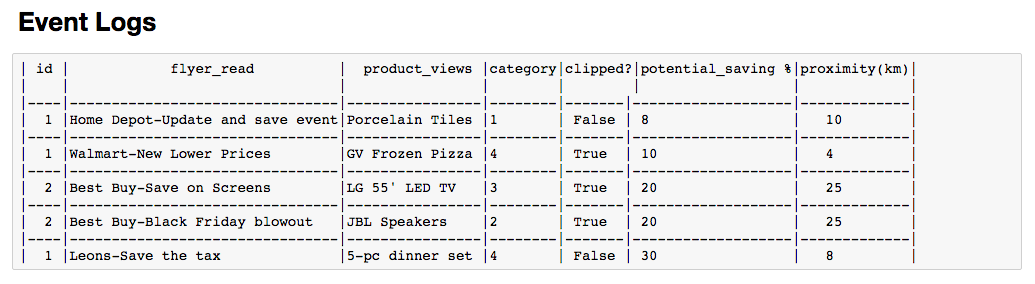

In [4]:
from IPython.display import Image
Image(filename='1.png')

## Assumptions

1. A clip event comprises of itself and a view event (Item cannot be clipped without viewing)
2. A view event can happen independently
3. Category mapping is done on core service back end which eventually lands on raw log files.
4. Saving offers on flyers and proximity measures for users are already available in raw log files.
5. Clip events will hold higher weightage in terms of effect on overall DOI.
6. Flipp has a static priroty order of flyer stack for each customer i.e it has measures such as location of a user and shows all flyers in a 5-mile to 20-mile radius based on zip code or GPS.
7. All four explicit columns have equal importance unless differentiated by a view or clip event.


#The Algorithm

**Case Event : View-Only**  
- In order to determine overall interest we will install frequency counters for each of the 4 explicit columns. 
- These frequency counters will help us gauge the weightage of a particular entry both within a column and also across all columns.
- For a particular column all the possible terms for a particular user will be extracted in a dictionary type data structure with their frequency e.g for column `category` in case of Alice:  
  - {furniture:1, home_electronics:0, ent_accessories:0, food_cutlery:2}. 
- The normalized score for each category would be calculated by taking the weighted average i.e for furniture -> 1/3 = 0.33, food_cutlery = 0.66
- The corrresponding score would be assigned to that particular item in a column
- Finally a total score would be calculated based on the descriptions of the flyers in the flipp stack  

**Case : Clip Event**
- All steps would be same as above except that a +3(or any suitable value) would be added to the view-only frequency to give higher weightage 






##Use Case

Lets explain a particular use case to better understand this. Lets assume that based on Alice's past browsing pattern  we have generated the following frequency **scoring mechanism** for **Alice**:

Flyer Category:

1. Furniture                  0.16 (Freq:1, 1/6)
2. Home Electronics           0.00
3. Entertainment Accessories  0.00
4. Food and cutlery           0.84 (Freq: 4+1=5, 5/6) --(Walmart event was a clip because of which 1+3=4)

Potential Saving:
1. less than 10%               0.16 (1/6) 
2. 10`-`20%                    0.66  ((1+(3))/6)
3. greater than 20%            0.16  (1/6)

Proximity:
1. less than 5km              0.66 (4/6)
2. 5`-`10                     0.33 (2/6)
3. greater than 10km          0.00
 
Brand Preference:    
1. Home Depot                 0.16  
2. Walmart                    0.66  
3. Leon's                     0.16  
4. BestBuy                    0.00  


Now lets assume that flipp has numerous flyers in its stack ,in context of Alice,which need to be reordered. Following is the **static** order of a particular stack:

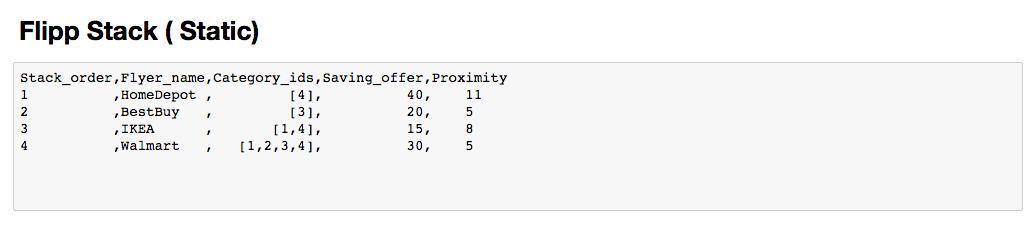

In [5]:
from IPython.display import Image
Image(filename='2.png')

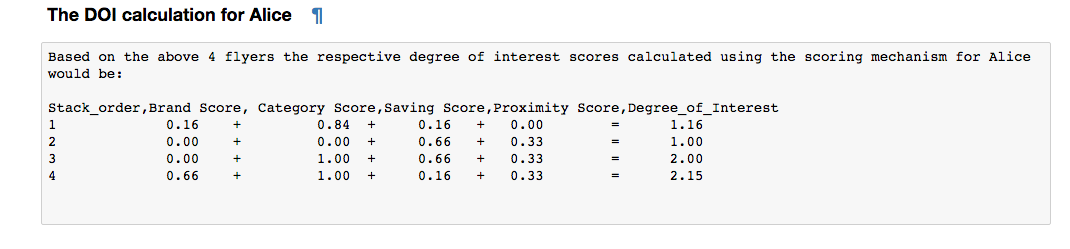

In [7]:
from IPython.display import Image
Image(filename='4.png')

### Use Case Notes


1. Even though _IKEA_ is a brand that was new to Alice's history, still based on the DOI calculated above it would take second precedence in the overall stack due to Alice's viewing patterns. 
2. The rough ranges generated for this example are for simplicity. This is just to illustrate the concept of scoring otherwise finding optimum number of ranges and their respective lengths is a separate topic that would require considerable insight. 

__Based on the Degree of Interest Scores the new stack ordering for Alice would be 4,3,1,2. Therefore now whenever Alice opens the Flipp App, the updated DOI scores would be fetched for the available stack of flyers and as a result she would see flyers from Walmart on the top,followed by IKEA,Home Depot and BestBuy . Even though this data is insufficient to make any conclusions about Alice's choices, if given access to the right amounts of data, these frequency ratios would self normalize themselves near their true values.__

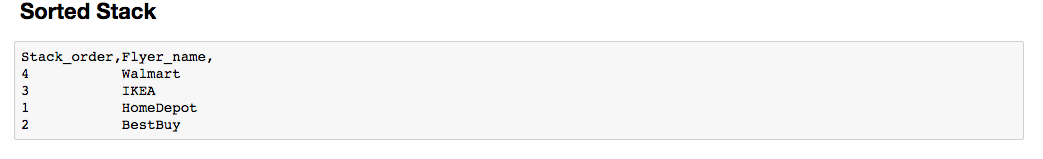

In [6]:
from IPython.display import Image
Image(filename='3.png')